This notebook is a direct following of the previous [Parallel_STLaurentDeJourdes](Parallel_STLaurentDeJourdes.ipynb). Here are the hypothesis considered. 
* At the beginning of period k (or end of period k-1), one must compute a command $P_{inj}^i(k) \hspace{10px}\forall i \in {1, \ldots, N}$, where $N$ the total number of controllable Sgens in the network.

In [1]:
#Import Modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandapower as pp
from pandapower.control.controller.const_control import ConstControl
from pandapower.timeseries.data_sources.frame_data import DFData
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.timeseries.output_writer import OutputWriter
from pandapower.plotting import simple_plot,simple_plotly,pf_res_plotly
import math as mt
import pandapower.plotting as pt
from pandapower.plotting.plotly import simple_plotly
from tqdm import tqdm # Profiling 
import seaborn as sbn
import time
import ipyparallel as ipp # Parallelization module
import pickle, sys, importlib


In [2]:
import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import myFunctions as mf
import myFunctions

In [3]:
from myFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [4]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

Compute the totalpower  of BT prod and Load on St Laurent 


In [5]:
# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


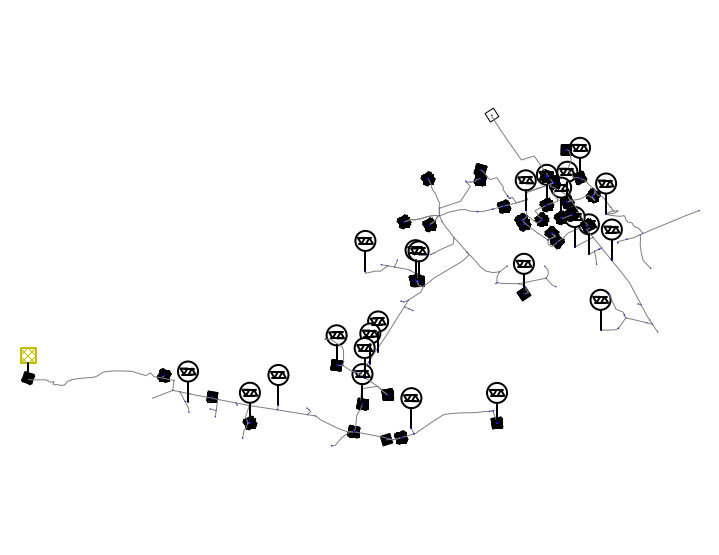

<AxesSubplot:>

In [6]:
simple_plot(net_civaux,bus_size=0.02,plot_sgens=True,sgen_size=2)

In [7]:
row2read = 8784 # Total number of rows for year 2020

#Load files
file_p_inj_0013 = 'Prod_HTA/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'

# The  commissioning of the Prod P0100 is recent (2022). I upscale the prod P0013 (*10)
# and consider it as that of Prod P0100
upscale_factor = 10


# Get files data 
p_mw_0013 = mf.readAndReshape_input(file_p_inj_0013 ,excel_folder, row2read)
p_mw_0018 = mf.readAndReshape_input(file_p_inj_0018 ,excel_folder, row2read)
p_mw_0100 = p_mw_0013*upscale_factor
p_mw_prod_bt_total = mf.readAndReshape_input(file_prod_bt_total, excel_folder)
p_mw_cons_total = mf.readAndReshape_input(file_cons_total, excel_folder)

# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0013), freq='10T')


# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013, 
                'P0018': p_mw_0018,
                'P0100': p_mw_0100}

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])

# Dataframe Conso BT 
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index)

# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

#### Plot Total prod BT and Total Load demand

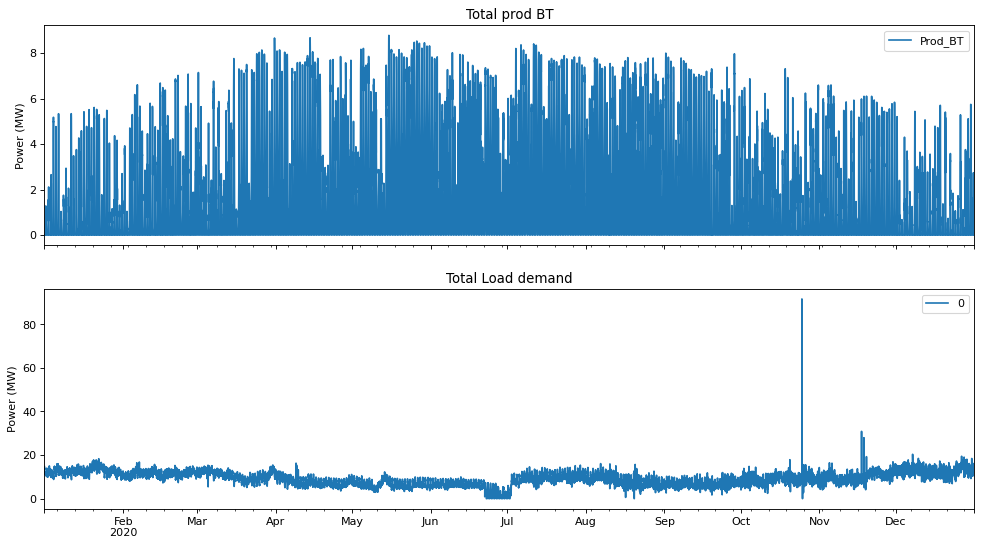

In [8]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prod_bt_total.plot(ax=axx[0], label = 'prod_bt_total', ylabel='Power (MW)', title='Total prod BT' )
df_cons_total.plot(ax=axx[1], label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

In the previous figure, the pic of demand occurring toward the end of October does not make sense. The disparity is undoubtedly due to a recording error. We will replace the recorded value with the mean of the previous and following periods

In [9]:
max_indx = df_cons_total[0].argmax()  # Get the indice of the period where the pic occurs

# replace the value with the mean of the previous and following periods
df_cons_total[0][max_indx] = (df_cons_total[0][max_indx-1] + df_cons_total[0][max_indx-1])/2

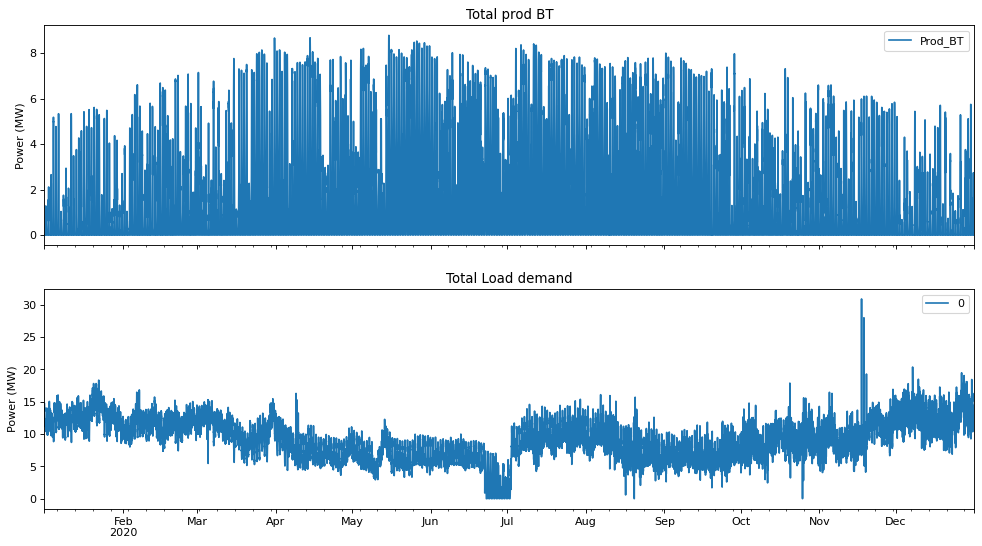

In [10]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prod_bt_total.plot(ax=axx[0], label = 'prod_bt_total', ylabel='Power (MW)', title='Total prod BT' )
df_cons_total.plot(ax=axx[1], label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

#### Zoom on the end of june of the total demand

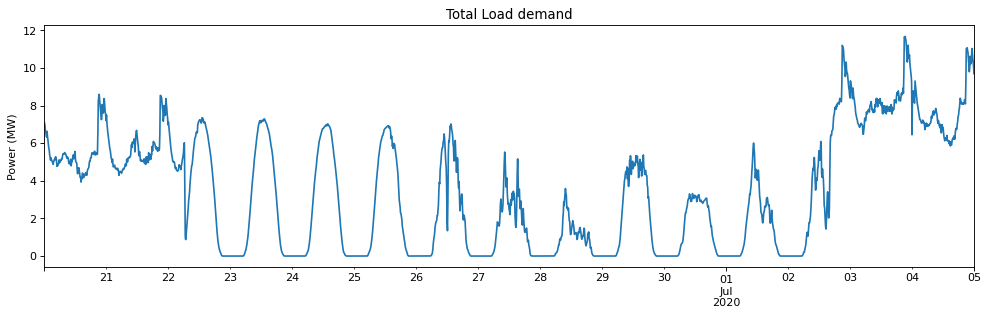

In [11]:
plt.figure(figsize=(15,4),dpi=80) 
bool_cond = (per_index >= '06 20 2020') & (per_index <= '07 05 2020' )
df_cons_total[0][bool_cond].plot(label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

<div class="alert alert block alert-danger ">
    <b>Important:</b> Total load demand follows a PV production cycle like from 2020-06-22 to 2020-07-03 included   
</div>    

#####  Use the mean of data from the 11 surrounding days from both side to reconstruct it., i.e. 06-11 to 06-21 and 07-03 to 07-13

In [12]:
previous_days = df_cons_total[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_cons_total[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2

#### Check wether the wrong data have been replaced

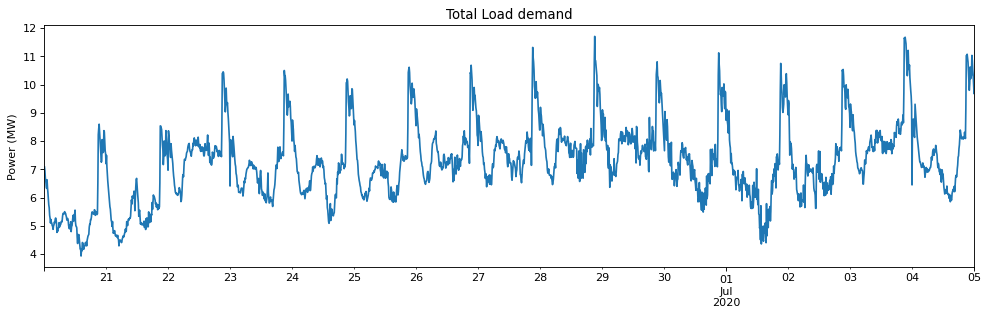

In [13]:
plt.figure(figsize=(15,4),dpi=80) 
bool_cond = (per_index >= '06 20 2020') & (per_index <= '07 05 2020' )
df_cons_total[0][bool_cond].plot(label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

#### Plot Total prod HT 

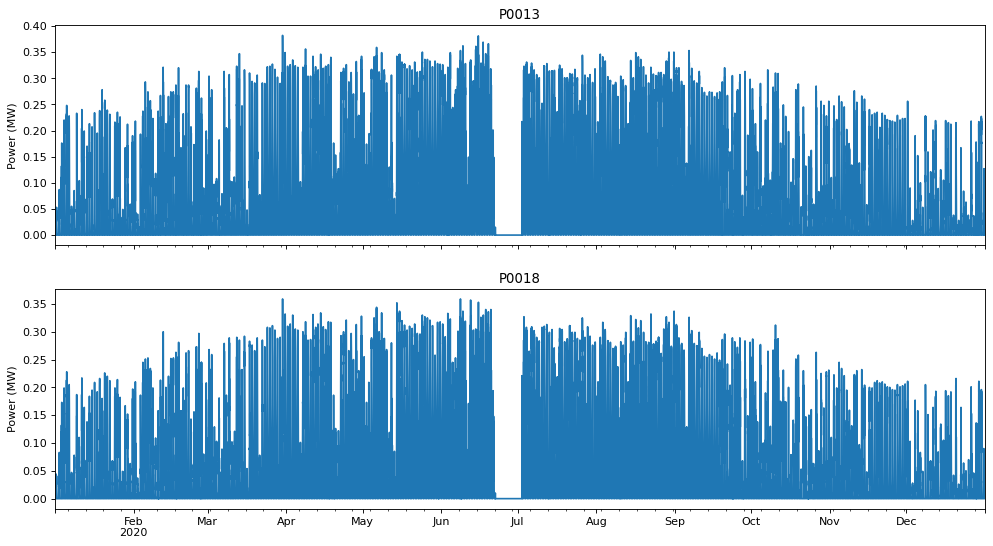

In [14]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prodHT['P0013'].plot(ax=axx[0], title='P0013', ylabel='Power (MW)')
df_prodHT['P0018'].plot(ax=axx[1], title='P0018', ylabel='Power (MW)');

### Highlight where data is missing

<AxesSubplot:>

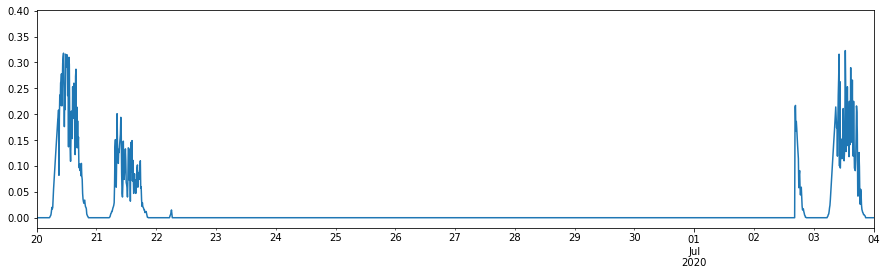

In [15]:
df_prodHT['P0013'].plot(xlim=('06 20 2020', '07 04 2020'), figsize=(15,4))

<div class="alert alert-block alert-danger">
<b>IMPORTANT:</b>
11 Days of data are missing (06-22 to 07-03)
</div>

##### Use the mean of data from the 11 surrounding days from both side to reconstruct it., i.e. 06-11 to 06-21 and 07-03 to 07-13

In [16]:
# Extract previous and following days 
previous_days = df_prodHT[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_prodHT[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]

# Put the interpolated data into the dataframe
df_prodHT[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                          np.array(previous_days) )/2

### Replot data to verify

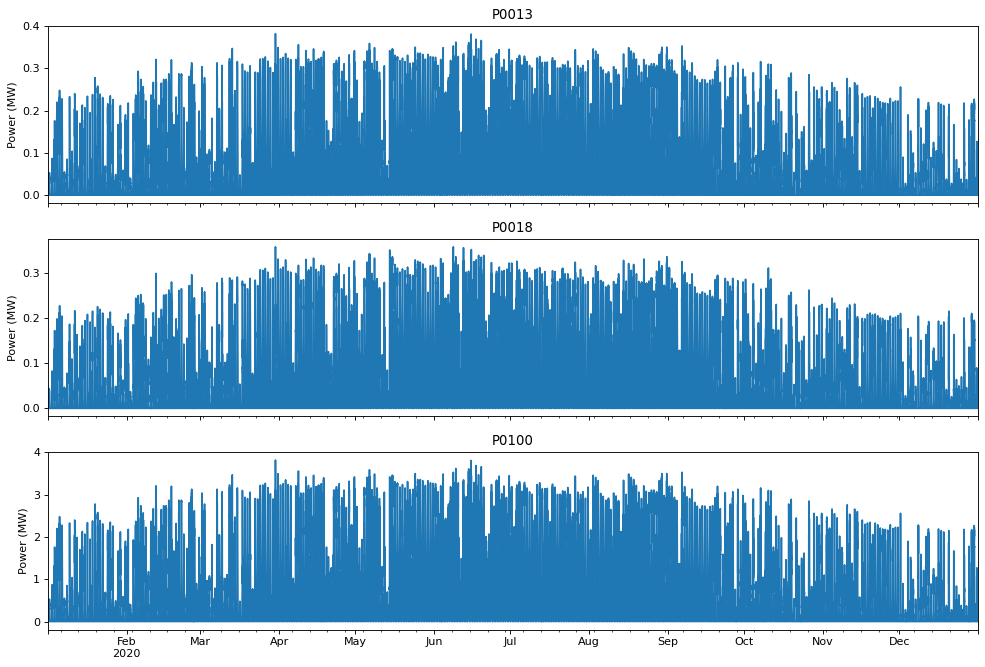

In [17]:
fig, axx = plt.subplots(3, figsize=(15,10),dpi=80, sharex=True) 
df_prodHT['P0013'].plot(ax=axx[0], title='P0013', ylabel='Power (MW)')
df_prodHT['P0018'].plot(ax=axx[1], title='P0018', ylabel='Power (MW)');
df_prodHT['P0100'].plot(ax=axx[2], title='P0100', ylabel='Power (MW)');

#### Extract activated bus 

In [18]:
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index 
                               if i in net_civaux_hv_bus.index]

dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

#### Create daylight period mask 

In [19]:
daylight_mask = (df_prodHT.P0013>0)|(df_prodHT.P0018>0)|(df_prodHT.P0100>0)|(df_prod_bt_total.Prod_BT>0)

In [20]:
# yeah = myFunctions.run_powerflow(net_civaux,
#                           net_civaux_hv_activated_bus,
#                           sum_max_main_network, dict_df_sgenLoad)

# [myFunctions.run_powerflow_at(net_civaux, curr_period, 
#                               net_civaux_hv_activated_bus, 
#                               sum_max_main_network,  
#                               dict_df_sgenLoad, False) for curr_period in df_prodHT.index[:10] ]

#### Run Power flow for each instant

In [21]:
# Create elm for parallel running

n_engines = 7  # Total number of engines
# (Use the real maximum cpu and not the logical)            
cluster = ipp.Cluster(n=n_engines) # Create cluster
cluster.start_cluster_sync()       # Start cluster 
rc = cluster.connect_client_sync() # connect client
rc.wait_for_engines(n_engines)     # Wait for engines to be available for all clients
dview = rc[:]                      # Create a direct view of all engine or clients that would
                                   # be used to command each client

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

## Run optimal power flow 

In [22]:
net_civaux2=pp.from_pickle(f'{network_folder}CIVAUX.p') # Reload network with new name 

# Disable P0100
# net_civaux1.switch.loc[net_civaux1.switch.bus==7, 'closed'] = False 

# Add a controllable line to the static generators
net_civaux2.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
net_civaux2.sgen['controllable'][net_civaux2.sgen.name=='P0100'] = True

# Add Missing columns to be able to un an opf 
net_civaux2.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
net_civaux2.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

net_civaux2.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
net_civaux2_hv_bus = list(net_civaux2.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

# net_civaux2_hv_bus = net_civaux2_hv_bus[net_civaux1_hv_bus.max_vm_pu.notna()]

pp.runpp(net_civaux2) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(net_civaux2.res_bus.vm_pu[net_civaux2.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux2_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in net_civaux2_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [23]:
vm_mu_max, vm_mu_min = 1.0225, 0.95  # Choose 

# net_civaux2.bus.max_vm_pu[net_civaux2.bus.max_vm_pu.notna()] = vm_mu_max
net_civaux2.bus.max_vm_pu[net_civaux2_hv_activated_bus] = vm_mu_max
net_civaux2.bus.min_vm_pu[net_civaux2_hv_activated_bus] = vm_mu_min


#### Add cost to optimal flow 

In [24]:
# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
cost_sgen_p0100 = pp.create_poly_cost(net_civaux2,23,'sgen', cp1_eur_per_mw=-1)
# net_civaux2.poly_cost.cp1_eur_per_mw.at[cost_sgen_p0100]=-0.5
net_civaux2.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


---

### NO control 

In [108]:
# Updata main dictionnary
dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

# Clear the localspace of all engines
dview.clear() 

# Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy, pandapower,pandas, par_myFunctions, tqdm, importlib

    
# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', per_index)

# Create a dictionnary containing all the varible that will be used by each client or engine
opf_status = False
parameters_dict = dict({'net_civaux2':net_civaux2, 
                        'net_civaux2_hv_activated_bus':net_civaux2_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


<AsyncResult(_push): pending>

#### Run Power flow

In [109]:
%%px
resulting_NOcontrol = [par_myFunctions.run_powerflow_at(net_civaux2, cur_period, net_civaux2_hv_activated_bus, 
                                              sum_max_main_network, dict_df_sgenLoad, vm_mu_max, opf_status,) 
             for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

In [110]:
# Gather the result of each engine in a single list
par_results = dview.gather('resulting_NOcontrol')

# Put data in dataframe
max_vm_pu_NoControl_df = pd.DataFrame(data=np.array(par_results), 
                                index=per_index, columns=['max_vm_pu_NoControl'],)

### Perfect Prediction of the future

In [111]:
# Shuffle period index so that the parallel cores can take different part and work on in 
# otherwise the basic separation would not be effective 
from sklearn.model_selection import train_test_split 
per_index_shuffleA, per_index_shuffleB = train_test_split(per_index,test_size=0.5, shuffle=True)

# Get the shuffled period index in a unique list
per_index_shuffle = [per for per in per_index_shuffleA] + [per for per in per_index_shuffleB]

In [112]:
# Clear the localspace of all engines
dview.clear() 

# Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy, pandapower,pandas, par_myFunctions, tqdm, importlib

    
# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', per_index_shuffle)

# Create a dictionnary containing all the varible that will be used by each client or engine
opf_status = 'Both' 
parameters_dict = dict({'net_civaux2':net_civaux2, 
                        'net_civaux2_hv_activated_bus':net_civaux2_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


<AsyncResult(_push): pending>

#### Run Optimal Power flow for each instant

In [113]:
%%px
resulting = [par_myFunctions.run_powerflow_at(net_civaux2, cur_period, net_civaux2_hv_activated_bus, 
                                              sum_max_main_network, dict_df_sgenLoad, vm_mu_max, opf_status,) for cur_period in period_part]


%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

In [114]:
# Gather the result of each engine in a single list
par_results = dview.gather('resulting')


In [115]:

# Extract result and save in a df
extracted_par_results = mf.extract_par_results(par_results, df_prodHT)

# # Get injected PV production for all (3) HT producers
df_sgen_HT = extracted_par_results.iloc[:,-3:]

# # Get maximum volatage over the network 
max_vm_pu_df = extracted_par_results[['max_vm_pu']]

Text(0.5, 1.0, 'Maximum voltage on all the bus in the network')

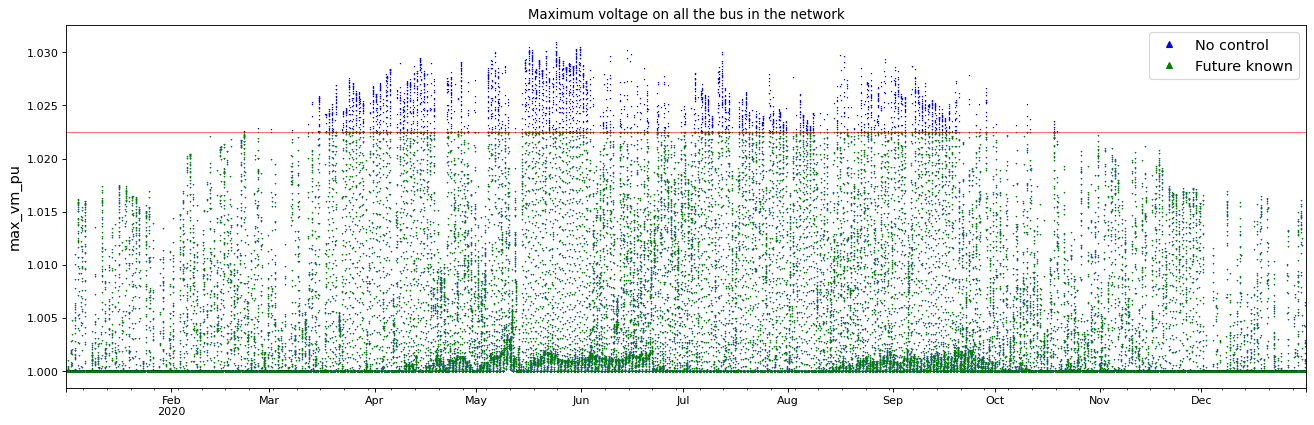

In [116]:
fig, axx = plt.subplots(figsize=(20,6), dpi=80)
max_vm_pu_NoControl_df.plot(ax=axx, style='b^',  markersize=0.5)
# max_vm_pu_df1.plot(ax=axx, style='r*', markersize=0.5)
max_vm_pu_df.plot(ax=axx, style='g^', markersize=0.5)
plt.axhline(vm_mu_max,color='r', lw=0.5)
plt.ylabel('max_vm_pu', fontsize=13)
plt.legend(['No control','Future known'],fontsize=13, markerscale=10)
plt.title("Maximum voltage on all the bus in the network",)
# plt.xlim(['2020 01 01', '2020 02 01'])

---

### Persistence  Prediction of the future

In [173]:
# Clear the localspace of all engines
dview.clear() 

# Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy, pandapower,pandas, par_myFunctions, tqdm, importlib

    
# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', per_index)

# Create a dictionnary containing all the varible that will be used by each client or engine
opf_status = 'Both' 
pred_model = 'Pers'
parameters_dict = dict({'net_civaux2':net_civaux2, 
                        'net_civaux2_hv_activated_bus':net_civaux2_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status, 
                        'pred_model': pred_model})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


<AsyncResult(_push): pending>

#### Run optimal power flow on all engines

In [174]:
%%px 
resulting_Pers = [par_myFunctions.run_powerflow_at(net_civaux2, cur_period+1, 
                                              net_civaux2_hv_activated_bus, sum_max_main_network, 
                                              dict_df_sgenLoad, vm_mu_max, opf_status, pred_model) 
             for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

In [175]:
par_results_pers = dview.gather('resulting_Pers')

In [182]:

# Extract result and save in a df
extracted_par_results_per = mf.extract_par_results(par_results_pers, df_prodHT)

# Get injected PV production for all (3) HT producers
df_sgen_HT_per = extracted_par_results_per.iloc[:,-3:]

# Get maximum volatage over the network 
max_vm_pu_df_per = extracted_par_results_per[['max_vm_pu']]
max_vm_pu_pf_df_per = extracted_par_results_per[['max_vm_pu_pf']]

In [184]:
# Add result to existing DF and implement bloc PROD

df_sgen_HT['P0100_No_Control'] = df_prodHT.P0100
df_sgen_HT['P0100_Persistence'] = np.nan;


# Implementing the Prod_min bloc from the figure 
# The persistence model output is given by the minimum between the power asked to the producer and its 
# actual production since it cannot produce more than what is asked
df_sgen_HT.P0100_Persistence[1:] = np.minimum(df_sgen_HT.P0100_No_Control[1:], df_sgen_HT_per.P0100[:-1])

<AxesSubplot:>

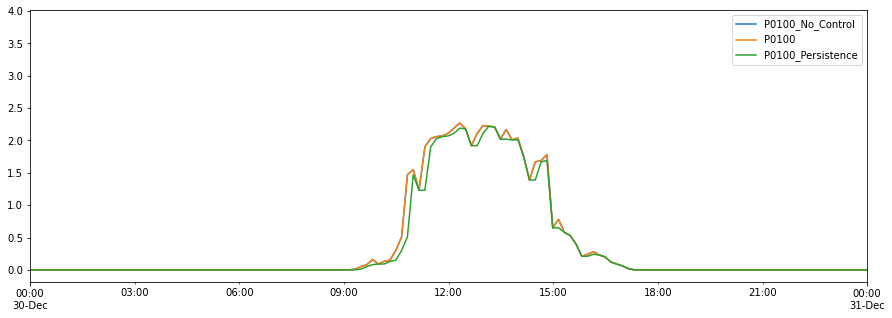

In [186]:
fig, axx = plt.subplots(figsize=(15,5))
# df_prodHT[['P0100']].plot( ax=axx)
df_sgen_HT[['P0100_No_Control','P0100','P0100_Persistence']].plot(xlim=('2020 12 30', '2020 12 31'), ax=axx)
# plt.ylim(0,.6).plot()

#### Run power flow with predicted persistence model output and check network state

In [187]:
#updata dictionary to use for sime power flow with persistence 
dict_df_sgenLoad = dict({'df_prodHT':df_sgen_HT[['P0013', 'P0018', 'P0100_Persistence',]][1:], 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

In [188]:
# Clear the localspace of all engines
dview.clear() 

# Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy, pandapower,pandas, par_myFunctions, tqdm, importlib

    
# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', per_index[1:])

# Create a dictionnary containing all the varible that will be used by each client or engine
opf_status = False 
pred_model = 'Pers'
parameters_dict = dict({'net_civaux2':net_civaux2, 
                        'net_civaux2_hv_activated_bus':net_civaux2_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status, 
                        'pred_model': pred_model})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


<AsyncResult(_push): pending>

#### Run optimal power flow on all engines

In [189]:
%%px 
resulting_pf_per = [par_myFunctions.run_powerflow_at(net_civaux2, cur_period, 
                                              net_civaux2_hv_activated_bus, sum_max_main_network, 
                                              dict_df_sgenLoad, vm_mu_max, opf_status) 
             for cur_period in period_part]



%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

In [190]:
# Gather the result of each engine in a single list
par_results_pf_per = dview.gather('resulting_pf_per')

In [194]:
# Put data in dataframe
max_vm_pu_per_df = pd.DataFrame(data=np.array(par_results_pf_per), 
                                index=per_index[1:], columns=['max_vm_pu_per'],)

Text(0.5, 1.0, 'Maximum voltage on all buses in the network')

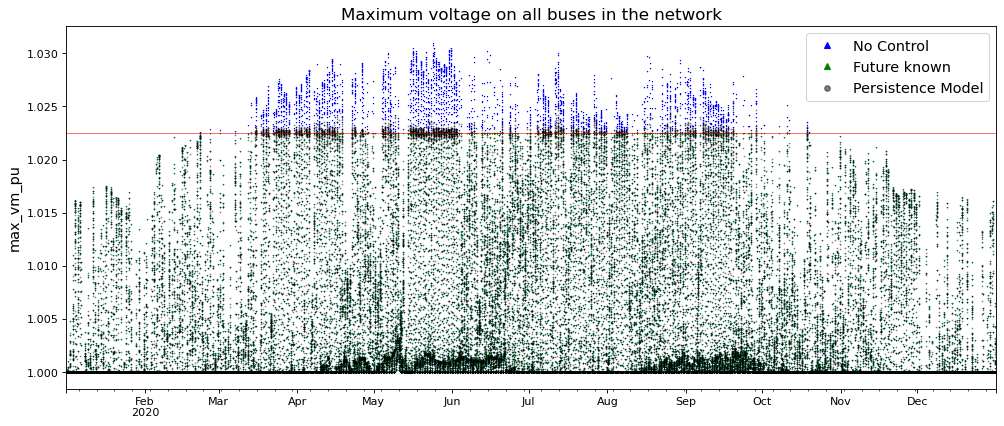

In [198]:
fig, axx = plt.subplots(figsize=(15,6), dpi=80)
max_vm_pu_NoControl_df.plot(ax=axx, style='b^',  markersize=0.5)
max_vm_pu_df.plot(ax=axx, style='g^', markersize=0.5)
max_vm_pu_per_df.plot(ax=axx, style='ko', markersize=0.5, alpha=0.5)

# aa.plot(ax=axx, style=['^','*','o'],color=['b','g','k'], markersize=0.5)

plt.axhline(vm_mu_max,color='r', lw=0.5)
plt.ylabel('max_vm_pu', fontsize=13)
plt.legend(['No Control','Future known', 'Persistence Model' ],fontsize=13, markerscale=10)
plt.title("Maximum voltage on all buses in the network",fontsize=15,)
# plt.xlim(['2020 05 01', '2020 05 10']);
# plt.ylim(1.020,1.030)

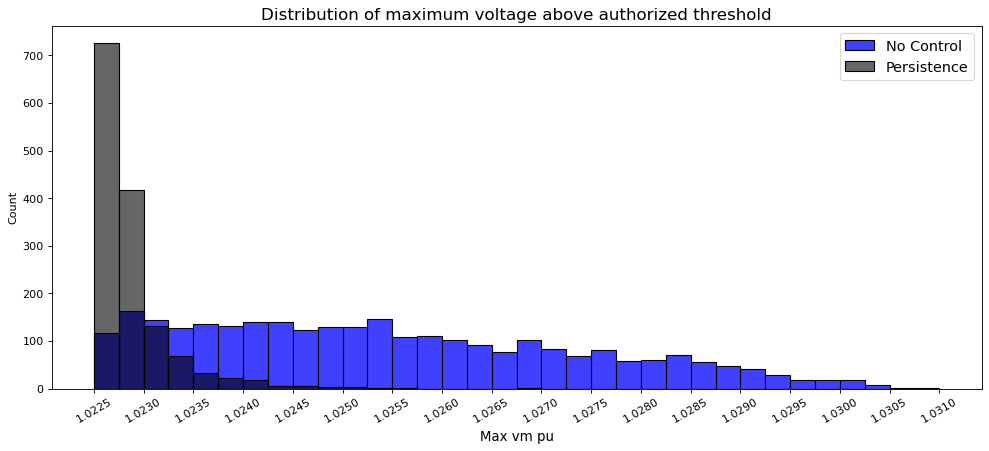

In [193]:
# Concatanate distribution data for the 
disdata = pd.concat([max_vm_pu_per_df[max_vm_pu_per_df.max_vm_pu_per>vm_mu_max], 
                     max_vm_pu_NoControl_df[max_vm_pu_NoControl_df.max_vm_pu_NoControl>vm_mu_max]], axis=1) 


fig, axx = plt.subplots(figsize=(15,6), dpi=80)
sbn.histplot(data = disdata, x=disdata.columns[1], ax=axx, bins=34, binrange=(1.0225, 1.0310), color='blue',)
sbn.histplot(data = disdata, x=disdata.columns[0], ax=axx, bins=34, binrange=(1.0225,1.0310), color='black', alpha=0.6)

axx.set_xticks(np.arange(1.0225, 1.0311, 5e-4), labels=[f'{elm:.4f}' for elm in np.arange(1.0225, 1.0311, 5e-4)], rotation=30);
axx.set_xlabel('Max vm pu', size=12)
plt.legend(['No Control', 'Persistence'], fontsize=13)
plt.title('Distribution of maximum voltage above authorized threshold', fontsize=15);

In [161]:
# mask2 = df_prodHT.loc[daylight_mask,'P0100']>0 # Define a mask for all instant where there production is > 0 for the producenr P0100
# mask3 = df_prodHT['P0100']>0;

# int_var = df_prodHT.loc[daylight_mask,'P0100'][mask2]  #  Intermediate variable

# perc_not_injected_perFuture[mask3] =( 100*(int_var - prod_curt_perFuture_mw_df[mask2].round(decimals=4).loc[:,0])/
#                                       int_var ).values.reshape((len(perc_not_injected[mask3]),1))



In [712]:
prod_no_curt_mwh = df_prodHT.loc[daylight_mask,['P0100']].sum()*Δt  # P0100 energy production when not curtailed

prod_curt_perFuture_mw = np.array(df_sgen_HT.loc[daylight_mask,'P0100'])        # P0100 power production after curtailement
prod_curt_perFuture_mwh = prod_curt_perFuture_mw.sum(axis=0)*Δt                 # P0100 energy production after curtailed
prod_curt_perFuture_mw_df = pd.DataFrame(data=prod_curt_perFuture_mw, 
                                         index=per_index[daylight_mask])


prod_curt_pers_mw = np.array(df_sgen_HT.P0100_Persistence[1:][daylight_mask])  # P0100 power production after curtailement
prod_curt_pers_mwh = prod_curt_pers_mw.sum(axis=0)*Δt                          # P0100 energy production after curtailed
prod_curt_pers_mw_df = pd.DataFrame(data=prod_curt_pers_mw, 
                                    index=per_index[daylight_mask])

# Percentage of power not injected into the grid during the year considered
perc_not_injected_perFuture_mw = np.round((df_prodHT.loc[daylight_mask,'P0100']-prod_curt_perFuture_mw)*100/
                                          df_prodHT.loc[daylight_mask,'P0100'], decimals=2)
perc_not_injected_pers_mw = np.round((df_prodHT.loc[daylight_mask,'P0100']-prod_curt_pers_mw)*100/
                                     df_prodHT.loc[daylight_mask,'P0100'], decimals=2)

# Percentage of energy not injected into the grid during the year considered
perc_not_injected_perFuture_mwh = np.round((prod_no_curt_mwh-prod_curt_perFuture_mwh)*100/prod_no_curt_mwh, decimals=2)
perc_not_injected_pers_mwh      = np.round((prod_no_curt_mwh-prod_curt_pers_mwh)*100/prod_no_curt_mwh, decimals=2)


prod_curt_perFuture_mw_df[prod_curt_perFuture_mw_df<1e-6]=0 # replace lower value (lower than 1wh) by 0
prod_curt_pers_mw_df[prod_curt_perFuture_mw_df<1e-6]=0      # replace lower value (lower than 1wh) by 0


print(f'P0100 prod,   No Control  : {prod_no_curt_mwh[0]:.2f} MWh')
print(f'P0100 prod, Future known  : {prod_curt_perFuture_mwh:.2f} MWh |  Perc = {prod_curt_perFuture_mwh*100/prod_no_curt_mwh[0]:.2f}%')
print(f'P0100 prod, Persis model  : {prod_curt_pers_mwh:.2f} MWh |  Perc = {prod_curt_pers_mwh*100/prod_no_curt_mwh[0]:.2f}%')
# print(f'Percentage of total \n      energy not injected : {perc_not_injected[0]} %')


P0100 prod,   No Control  : 5033.34 MWh
P0100 prod, Future known  : 4717.39 MWh |  Perc = 93.72%
P0100 prod, Persis model  : 4365.56 MWh |  Perc = 86.73%


##### Some Plots

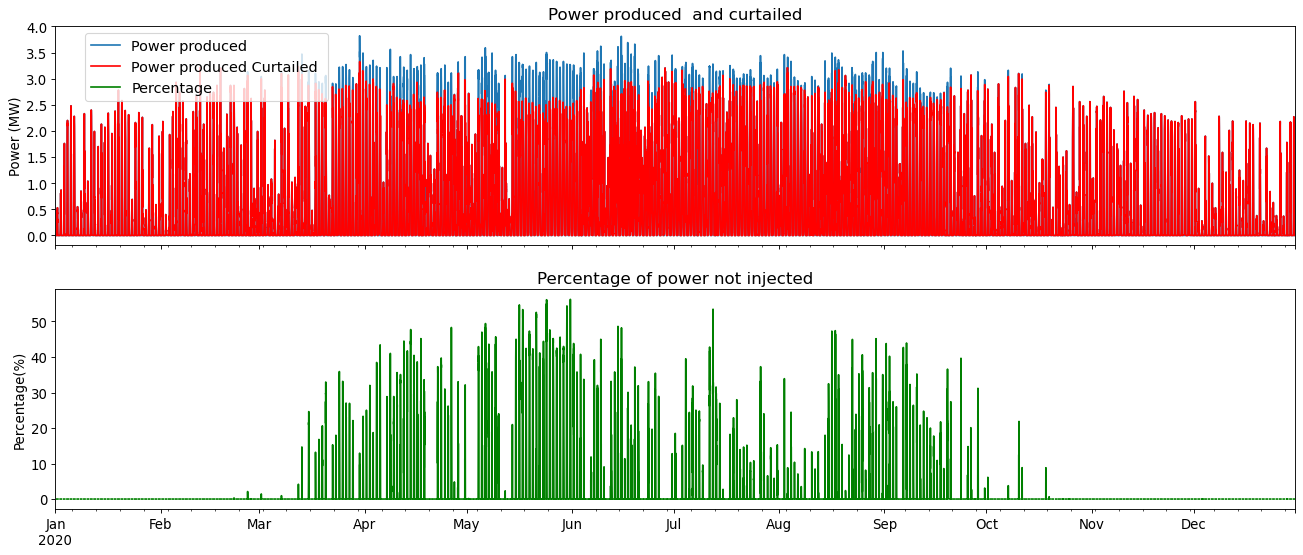

In [158]:
fig, axx = plt.subplots(2, figsize=(20,8), sharex=True, dpi=80)
df_prodHT.P0100.plot(ax=axx[0],legend=False)
prod_curt_perFuture_mw_df.plot(ax=axx[0], color='red',
                     legend=False,fontsize=12,)
axx[0].set_title('Power produced  and curtailed',fontsize=15)
axx[0].set_ylabel('Power (MW)',fontsize=12)



perc_not_injected_perFuture_mw.plot(ax=axx[1], color="green", legend=False,
                       xlim=['2020 01 01', '2020 12 31'], fontsize=12,)
axx[1].set_title('Percentage of power not injected', fontsize=15)
axx[1].set_ylabel('Percentage(%)',fontsize=12)

fig.legend(['Power produced','Power produced Curtailed ', 'Percentage'],
          loc='upper right', 
           bbox_to_anchor=(0.3, 0.88), 
           ncol=1, fontsize=13)
# plt.grid(axis='both', which='Both')

#### Plot Stats about the percentage of power not injected into the grid 

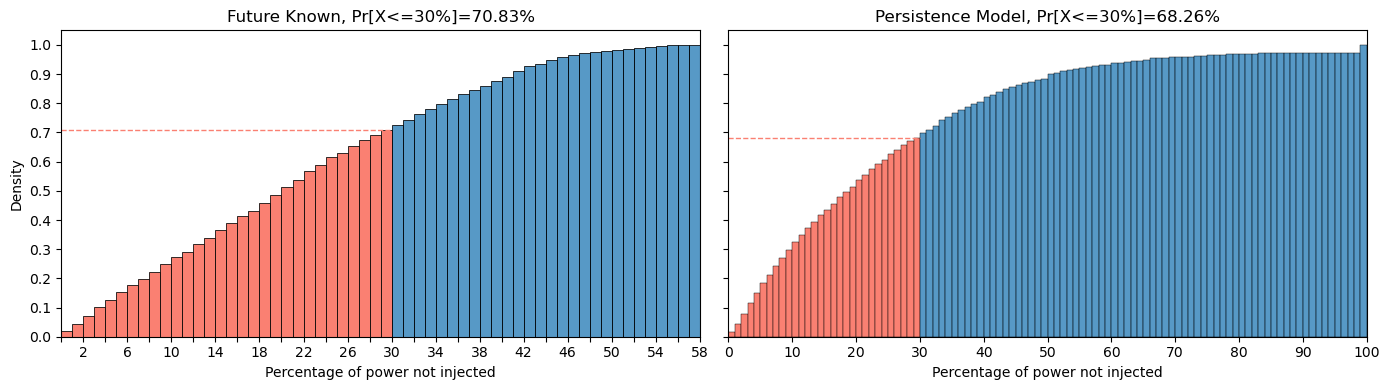

In [ ]:
statt = 'density'


fig, axx = plt.subplots(1,2, figsize=(14,4), dpi=100, sharey=True)

sbn.histplot(perc_not_injected_perFuture_mw[perc_not_injected_perFuture_mw>0],bins=58, binrange=[0,58],
             stat=statt, ax=axx[0], cumulative=True,
             legend=False, )

sbn.histplot(perc_not_injected_pers_mw[perc_not_injected_pers_mw>0],bins=100, binrange=[0,100],
             stat=statt, ax=axx[1], cumulative=True,
             legend=False, )


perc_to_consider= 30
perc_to_consider2= 30
for elm in axx[0].patches[:perc_to_consider]: elm.set_facecolor('salmon')
for elm in axx[1].patches[:perc_to_consider2]: elm.set_facecolor('salmon')


axx

x_maxx = axx[1].patches[perc_to_consider2].get_x()/100
axx[1].axhline(axx[1].patches[perc_to_consider2-1].get_height(),xmax=x_maxx, color='salmon', ls='--', lw=1)

x_maxx = axx[0].patches[perc_to_consider].get_x()/58
axx[0].axhline(axx[0].patches[perc_to_consider-1].get_height(),xmax=x_maxx, color='salmon', ls='--', lw=1)

[0].set(xlabel='Percentage of power not injected',
        yticks=np.arange(0,1.1,.1),
        xticks=range(0,60,2),
        title=f'Future Known, Pr[X<={perc_to_consider}%]={axx[0].patches[perc_to_consider-1].get_height()*100:.2f}%',
        xlim=(0,58),
        xticklabels=[i if elm%2==1 else '' for elm, i  in enumerate(range(0,60,2)) ]);
axx[1].set(xlabel='Percentage of power not injected',
        yticks=np.arange(0,1.1,.1),
        xticks=range(0,105,10),
        title=f,'Persistence Model, Pr[X<={perc_to_consider}%]={axx[1].patches[perc_to_consider2-1].get_height()*100:.2f}%'
        xlim=(0,100),
        );


fig.tight_layout()

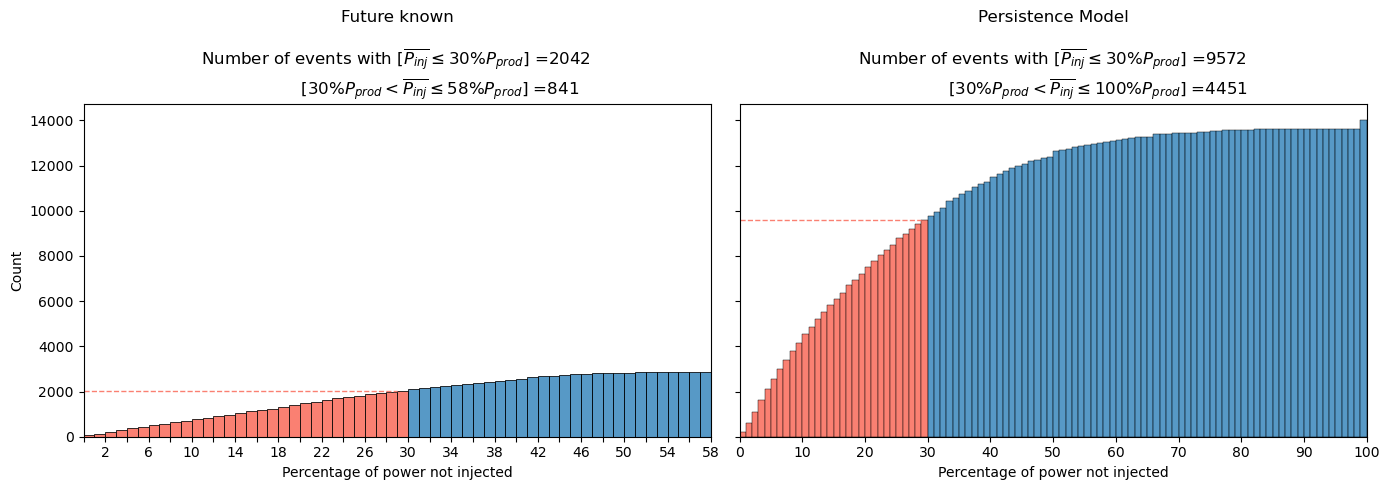

In [160]:
statt = 'count'
tick_lab = [i if elm%2==1 else '' for elm, i  in enumerate(range(0,60,2)) ]

fig, axx = plt.subplots(1,2, figsize=(14,5), dpi=100, sharey=True)

sbn.histplot(perc_not_injected_perFuture_mw[perc_not_injected_perFuture_mw>0],bins=58, binrange=[0,58],
             stat=statt, ax=axx[0], cumulative=True,
             legend=False, )

sbn.histplot(perc_not_injected_pers_mw[perc_not_injected_pers_mw>0],bins=100, binrange=[0,100],
             stat=statt, ax=axx[1], cumulative=True,
             legend=False, )


perc_to_consider= 30
perc_to_consider2= 30
for elm in axx[0].patches[:perc_to_consider]: elm.set_facecolor('salmon')
for elm in axx[1].patches[:perc_to_consider2]: elm.set_facecolor('salmon')

var1 = axx[0].patches[perc_to_consider-1].get_height()
var2 = axx[0].patches[-1].get_height() - var1 
axx[0].set(xlabel='Percentage of power not injected',
           title=(f'Future known\n\n'
               f'Number of events with [$\\overline{{P_{{inj}} }}\leq ${perc_to_consider2}%$P_{{prod}}$] ={var1} \n'
               f'\t\t[${perc_to_consider2}\%P_{{prod}} < \\overline{{P_{{inj}} }}\leq 58\% P_{{prod}}$] ={var2}'),
           xlim=(0,58),
           xticks=range(0,60,2),
           xticklabels=tick_lab);

var1 = axx[1].patches[perc_to_consider2-1].get_height()
var2 = axx[1].patches[-1].get_height() - var1 
axx[1].set(xlabel='Percentage of power not injected',
           xticks=range(0,105,10),
           title=(f'Persistence Model\n\n'
               f'Number of events with [$\\overline{{P_{{inj}} }}\leq ${perc_to_consider2}%$P_{{prod}}$] ={var1} \n'
               f' \t\t [${perc_to_consider2}\%P_{{prod}} < \\overline{{P_{{inj}} }}\leq 100\% P_{{prod}}$] ={var2}'),
           xlim=(0,100),
        );


x_maxx = axx[0].patches[perc_to_consider-1].get_x()/58
axx[0].axhline(axx[0].patches[perc_to_consider-1].get_height(),xmax=x_maxx, color='salmon', ls='--', lw=1)

x_maxx = axx[1].patches[perc_to_consider2-1].get_x()/100
axx[1].axhline(axx[1].patches[perc_to_consider2-1].get_height(),xmax=x_maxx, color='salmon', ls='--', lw=1)


fig.tight_layout()

### Persistence  Prediction of the future improved
Variables saved cells are to be used in [ParPers_improve_STLaurentDeJourdes](ParPers_improve_STLaurentDeJourdes.ipynb)

In [722]:
var_STLaurentDeJourdes = dict({'extracted_par_results_per': extracted_par_results_per,
                               'df_sgen_HT':                df_sgen_HT,
                               'prod_curt_perFuture_mw':    prod_curt_perFuture_mw, 
                               'df_prodHT':                 df_prodHT, 
                               'df_prod_bt_total':          df_prod_bt_total,
                               'df_cons_total': df_cons_total,
                               'max_vm_pu_NoControl_df': max_vm_pu_NoControl_df,
                               'max_vm_pu_df' :          max_vm_pu_df,
                               'max_vm_pu_per_df': max_vm_pu_per_df,
                               'disdata': disdata

                              } )

file_loc = 'pickle_files/simulationResults/'


with open(file_loc+"STLaurentDeJourdes_Par.pkl",'wb') as file: 
    pickle.dump(var_STLaurentDeJourdes,file)
